In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy import stats

# Style
sns.set(style="whitegrid")

In [2]:
# Step 1: Download and unzip

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

# Step 2: Load the FULL dataset

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2025-06-15 08:29:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [ <=>                ] 434.15K  --.-KB/s    in 0.09s   

2025-06-15 08:29:05 (4.96 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [4]:
# Add cost column
call_cost = 10  # ₹10 per call
df['call_cost'] = df['campaign'] * call_cost

In [6]:
# Channel-level summary
channel_summary = (
    df.groupby('contact')
    .agg(total_customers=('y', 'count'),
         conversions=('y', lambda x: (x == 'yes').sum()),
         avg_calls=('campaign', 'mean'))
    .reset_index()
)

# Cost metrics
channel_summary['total_cost'] = channel_summary['total_customers'] * channel_summary['avg_calls'] * call_cost
channel_summary['conversion_rate'] = (channel_summary['conversions'] / channel_summary['total_customers']) * 100
channel_summary['cost_per_conversion'] = channel_summary['total_cost'] / channel_summary['conversions'].replace(0, np.nan)

In [7]:
channel_summary

,contact,total_customers,conversions,avg_calls,total_cost,conversion_rate,cost_per_conversion
0,cellular,26144,3853,2.405026,628770.0,14.737607,163.189722
1,telephone,15044,787,2.850106,428770.0,5.231321,544.815756


In [8]:
# statistical Test

channel_contingency = pd.crosstab(df['contact'], df['y'])
chi2_stat_channel, p_val_channel, dof_channel, _ = stats.chi2_contingency(channel_contingency)

In [11]:
# statistical Test

contingency = pd.crosstab(df['month'], df['y'])
chi2, p, dof, _ = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f}, p = {p:.4f}")
print("✅ Significant difference" if p < 0.05 else "❌ Not statistically significant")

Chi² = 3101.15, p = 0.0000
✅ Significant difference


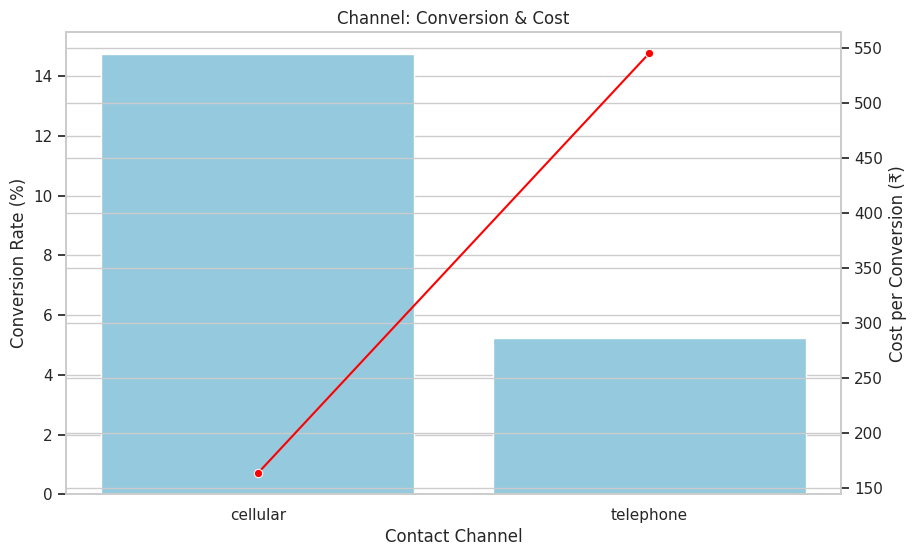

In [12]:
# visualization

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=channel_summary, x='contact', y='conversion_rate', ax=ax1, color='skyblue')
ax1.set_ylabel('Conversion Rate (%)')
ax1.set_xlabel('Contact Channel')

ax2 = ax1.twinx()
sns.lineplot(data=channel_summary, x='contact', y='cost_per_conversion', ax=ax2, marker='o', color='red')
ax2.set_ylabel('Cost per Conversion (₹)')
plt.title("Channel: Conversion & Cost")
plt.show()

In [15]:
# Convert target to binary
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# cost simulation
worst_segment = channel_summary.sort_values('cost_per_conversion', ascending=False).iloc[0]['contact']
df_sim = df[df['contact'] != worst_segment]
total_calls = df_sim['campaign'].sum()
total_conversions = df_sim['y'].sum()
total_cost = total_calls * call_cost
cost_per_conv = total_cost / total_conversions

print(f"Removing '{worst_segment}' saves cost per conversion: ₹{cost_per_conv:.2f}")

Removing 'telephone' saves cost per conversion: ₹163.19
